<a href="https://colab.research.google.com/github/nafisenik/NLP-CA2/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
!pip install ner-d

In [2]:
import os
import pandas as pd
from itertools import groupby
from operator import itemgetter
import re
from collections import Counter
import numpy as np
import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
import string
from collections import Counter



from nltk import regexp_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import RegexpParser
from nltk import FreqDist
from nltk.tokenize import sent_tokenize



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import spacy
from spacy import displacy

from nerd import ner

import datetime

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Download nltk packages

In [3]:
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### Read text files and save as a list

In [4]:
# a function to read files 
def read_file(file):
    with open(file, 'r', encoding="utf-8") as f:
        text = f.read()
    return text

# set path to text files
file_dir = './Data/Text_Files/'
text_list = []

# find files with .txt and read them
for file in os.listdir(file_dir):
    if file.endswith(".txt"):
        file_path = f'{file_dir}{file}'
        text_list.append(read_file(file_path))

In [5]:
print(f"number of texts: {len(text_list)}")

number of texts: 82


### Sample of our data

In [6]:
# sample text
print(f"sample text: {text_list[0][:500]}")

sample text: 
To the Congress of the United States:
We enter 1974 not at the beginning of an historical cycle, but in the middle of one. Beginnings have been made in many vital areas, beginnings which we now must build upon. New needs have arisen which we are in the process of addressing. Opportunities are coalescing which give us a chance to make historic progress toward a stable peace and expanding prosperity.
In looking at the agenda for 1974, we cannot consider the work of this or of any one year in isol


In [7]:
df = pd.read_csv("./Data/metadata.csv")
df.head()

,Index,President,Categories,Date,Citation,Title
0,0,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 06, 1947","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
1,1,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 07, 1948","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
2,2,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 05, 1949","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
3,3,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 04, 1950","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...
4,4,Harry S. Truman,"['Presidential', 'State of the Union Addresses...","January 08, 1951","Harry S. Truman, Annual Message to the Congres...",Annual Message to the Congress on the State of...


#### Change Date Type to datetime

In [8]:
print(df['Title'].dtypes)

object


In [9]:
df['Date'] = pd.to_datetime(df['Date'], format='%B %d, %Y')
df['Date']

0    1947-01-06
1    1948-01-07
2    1949-01-05
3    1950-01-04
4    1951-01-08
        ...    
77   2016-01-12
78   2018-01-30
79   2019-02-05
80   2020-02-04
81   2022-03-01
Name: Date, Length: 82, dtype: datetime64[ns]

### Groupby persidents:
`dict[president_name]` = `[texts]`


In [10]:
president_name = df['President'].tolist()
president_text_dict = {keys: [i for _, i in sub] for keys, sub in groupby(
         zip(president_name, text_list), key = itemgetter(0))}

In [11]:
president_text_dict.keys()

dict_keys(['Harry S. Truman', 'Dwight D. Eisenhower', 'John F. Kennedy', 'Lyndon B. Johnson', 'Richard Nixon', 'Gerald R. Ford', 'Jimmy Carter', 'Ronald Reagan', 'George Bush', 'William J. Clinton', 'George W. Bush', 'Barack Obama', 'Donald J. Trump', 'Joseph R. Biden'])

In [12]:
len(president_text_dict['Barack Obama'])

7

### Tokenizer

In [13]:
# http://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[a-zA-Z]\.)+(?:[a-zA-Z])?         # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''

pattern = re.compile(pattern)

def tokenize_text(text):
    return regexp_tokenize(text, pattern)

### Lemmatizer

In [14]:
def lemmatize_all(sentence):
    l = []
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(tokenize_text(sentence)):
        if tag.startswith('N'):
            l.append(wnl.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            l.append(wnl.lemmatize(word, pos='v'))
        elif tag.startswith('J'):
            l.append(wnl.lemmatize(word, pos='a'))
        elif tag.startswith('R'):
            l.append(wnl.lemmatize(word, pos='r'))
            
        else:
            l.append(wnl.lemmatize(word, pos='n'))
    return l

#### Test of lemmatizer

In [15]:
sentence_sample = 'The striped bats are  hanging on their feet for best and wrote you are'
print(lemmatize_all(sentence_sample))



['The', 'striped', 'bat', 'be', 'hang', 'on', 'their', 'foot', 'for', 'best', 'and', 'write', 'you', 'be']


### Normalizing and Cleaning

In [16]:
stop_words = set(stopwords.words('english'))
def normalize_and_cleaning(text, lemm=True, remove_punct=True, lower=True, stop_word=True, remove_number=True, min_len = 2):

    text = re.sub(r'(:?\[Laughter\]|\[Applause\]|\[applause\]|\[laughter\])', '', text)
    

    word_tokens = tokenize_text(text)
    
    if lower:
        text = text.lower()
    
    
    if remove_number:
        my_reg = r'\$?\d+\.?\d*\w*\d*'
        text = re.sub(my_reg, '', text)
    
    if remove_punct:
        #text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if len(word) > 1])
        text =' '.join([word.strip(punctuation) for word in tokenize_text(text) if word not in string.punctuation])
    
    if lemm:
      text = ' '.join(lemmatize_all(text))
    
    
    if stop_word:
        text = ' '.join([w for w in tokenize_text(text) if not w.lower() in stop_words])
    

    
    if min_len>1:
        text = ' '.join([word for word in tokenize_text(text) if len(word)>min_len])  

    
    text = re.sub(' +', ' ', text)
    
    return text
    
    

In [17]:
#Test normalize_and_cleaning
test_text ='''[Laughter]poster-print The President. That 1993s Asia—the asia-pacific 22nd 33nd33 6-year U.S.A. wrote good example. [Applause] Well—[applause]. are [Applause] costs $12.40... Michelle Move! u.'''
tokens = tokenize_text(test_text)
res = normalize_and_cleaning(test_text)
res2 = normalize_and_cleaning(test_text,remove_number=False)
print(res)

print(res2)



poster-print president asia asia-pacific year u.s.a write good example well cost michelle move
poster-print president 1993s asia asia-pacific 22nd 33nd33 6-year u.s.a write good example well cost michelle move


### Join all text and create our corpuse

In [18]:
all_doc = ' '.join(text_list)
clean_corpuse = normalize_and_cleaning(all_doc)
corpuse_tokens = tokenize_text(clean_corpuse)


### Most frequent words of our corpuse

In [19]:
counter = Counter(corpuse_tokens)
most_occur = counter.most_common(50)
corpuse_fre_df = pd.DataFrame.from_records(most_occur, columns =['word', 'frequency'])
total_freq = [(x[1]/len(corpuse_tokens))*100 for x in most_occur]
corpuse_fre_df['% total frequency'] = total_freq
corpuse_fre_df

,word,frequency,% total frequency
0,year,3291,1.132855
1,american,2114,0.727698
2,new,2047,0.704635
3,people,1904,0.655410
4,nation,1870,0.643707
5,must,1848,0.636134
6,make,1829,0.629593
7,congress,1828,0.629249
8,program,1773,0.610317
9,world,1747,0.601367


### Statistical information

In [20]:
def Statistical_info(text_tokens):
  print (f"Number of words : {len(text_tokens)}")
  print (f"Number of unique  words : {len(set(text_tokens))}")
  word_len_avg = sum(map(len, text_tokens))/float(len(text_tokens))
  print (f"Average word length : {word_len_avg}")
  sent_len_avg = np.mean([len(' '.join(s)) for s in text_tokens])
  max_w = max(text_tokens, key=len)
  min_w = min(text_tokens, key=len)
  print (f"Longest word : {max_w}")
  print (f"Shortest word : {min_w}")

### Word cloud of corpuse

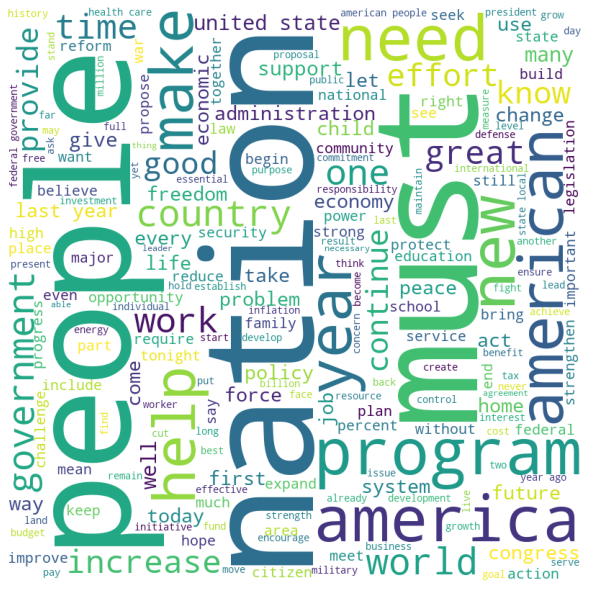

In [21]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(clean_corpuse)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Statistical information of corpuse

In [22]:
  print('*' *50)
  print('Statical information of corpus')
  print('*' *50)
  Statistical_info(corpuse_tokens)

**************************************************
Statical information of corpus
**************************************************
Number of words : 290505
Number of unique  words : 12245
Average word length : 6.419256122958297
Longest word : weapons-of-mass-destruction-related
Shortest word : one


### create new dictionary with clean text and tokenized text

In [23]:
cleaned_text_dict = {}
tokenized_text_dict = {}
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  cleaned_text_dict[president] = clean_text
  president_tokens = tokenize_text(clean_text)
  tokenized_text_dict[president] = president_tokens

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/14 [00:00<?, ?it/s]

In [24]:
president_tokenized_doc = {}

# tokenize president speaches
for president in cleaned_text_dict.keys():
    president_tokenized_doc[president] = tokenize_text(cleaned_text_dict[president])
    
# create frequents 
president_dataframe = {}
for opt in president_tokenized_doc.keys():
     president_dataframe[opt] = FreqDist(president_tokenized_doc[opt]).most_common(50)

freq_analysis_word = pd.DataFrame(president_dataframe)
freq_analysis_word

,Harry S. Truman,Dwight D. Eisenhower,John F. Kennedy,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump,Joseph R. Biden
0,"(year, 379)","(year, 340)","(year, 110)","(year, 367)","(year, 350)","(must, 97)","(world, 200)","(year, 360)","(year, 182)","(must, 173)","(year, 425)","(year, 211)","(year, 127)","(year, 44)"
1,"(new, 246)","(new, 246)","(american, 77)","(program, 320)","(american, 318)","(nation, 68)","(nation, 181)","(american, 231)","(program, 151)","(year, 160)","(congress, 312)","(american, 197)","(american, 101)","(congress, 31)"
2,"(must, 245)","(world, 220)","(congress, 68)","(must, 264)","(people, 293)","(people, 68)","(year, 175)","(make, 211)","(government, 101)","(nation, 154)","(program, 267)","(america, 178)","(america, 100)","(nation, 20)"
3,"(american, 242)","(program, 196)","(must, 64)","(new, 246)","(new, 274)","(government, 65)","(american, 167)","(program, 201)","(make, 90)","(world, 131)","(work, 224)","(new, 174)","(people, 73)","(think, 20)"
4,"(make, 223)","(nation, 193)","(nation, 60)","(nation, 228)","(work, 270)","(world, 64)","(must, 166)","(people, 199)","(congress, 88)","(people, 125)","(new, 220)","(people, 154)","(one, 67)","(believe, 17)"
5,"(people, 221)","(must, 192)","(new, 56)","(congress, 226)","(make, 252)","(year, 61)","(people, 162)","(congress, 186)","(nation, 88)","(american, 114)","(nation, 212)","(make, 139)","(make, 66)","(american, 16)"
6,"(work, 209)","(make, 186)","(people, 49)","(make, 211)","(america, 239)","(american, 60)","(new, 140)","(work, 185)","(continue, 86)","(america, 110)","(american, 204)","(nation, 129)","(new, 61)","(time, 15)"
7,"(help, 180)","(congress, 182)","(great, 47)","(government, 210)","(world, 203)","(america, 54)","(great, 125)","(new, 184)","(federal, 83)","(state, 109)","(state, 180)","(congress, 113)","(world, 55)","(make, 15)"
8,"(federal, 174)","(people, 176)","(world, 45)","(state, 208)","(nation, 197)","(make, 46)","(free, 113)","(government, 184)","(new, 77)","(government, 103)","(america, 175)","(need, 112)","(job, 53)","(world, 14)"
9,"(congress, 172)","(great, 167)","(last, 45)","(federal, 195)","(must, 196)","(one, 41)","(congress, 108)","(nation, 180)","(state, 77)","(make, 92)","(make, 171)","(state, 111)","(tax, 52)","(president, 13)"


###Statistical information for each president

In [25]:
for president, tokens_list in tokenized_text_dict.items():
  print('*' *50)
  print(president)
  print('*' *50)
  Statistical_info(tokens_list)


**************************************************
Harry S. Truman
**************************************************
Number of words : 31569
Number of unique  words : 4390
Average word length : 6.316544711584149
Longest word : agriculturally-related
Shortest word : one
**************************************************
Dwight D. Eisenhower
**************************************************
Number of words : 29902
Number of unique  words : 4161
Average word length : 6.36913918801418
Longest word : reservation-by-reservation
Shortest word : lie
**************************************************
John F. Kennedy
**************************************************
Number of words : 7888
Number of unique  words : 2248
Average word length : 6.267114604462475
Longest word : great-grandchildren
Shortest word : new
**************************************************
Lyndon B. Johnson
**************************************************
Number of words : 36317
Number of unique  words : 4933
Average 

## Extract Posetive, Negative and Neutral words

In [26]:
def extract_pos_neg(textTokens):
  sid = SentimentIntensityAnalyzer()
  pos_word_list=[]
  neu_word_list=[]
  neg_word_list=[]

  for word in textTokens:
      if (sid.polarity_scores(word)['compound']) >= 0.5:
          pos_word_list.append(word)
      elif (sid.polarity_scores(word)['compound']) <= -0.5:
          neg_word_list.append(word)
      else:
          neu_word_list.append(word)                

  print('Positive :',list(set(pos_word_list)))        
  print('Neutral :',list(set(neu_word_list)))    
  print('Negative :',list(set(neg_word_list))) 

In [27]:
for president, tokens_list in tokenized_text_dict.items():
  print('*' *250)
  print(president)
  print('*' *250)
  extract_pos_neg(president_tokens)

**********************************************************************************************************************************************************************************************************************************************************
Harry S. Truman
**********************************************************************************************************************************************************************************************************************************************************
Positive : ['peace', 'free', 'ideal', 'strong', 'best', 'love', 'confidence', 'wisdom', 'beloved', 'success', 'generous', 'rich', 'kind', 'loyalty', 'freedom', 'wonderful', 'pleasant', 'great', 'justice', 'liberty', 'gratitude']
Neutral : ['although', 'three', 'prospect', 'face', 'revenue', 'conclude', 'july', 'sense', 'personal', 'lend', 'soviet', 'precede', 'hospital', 'far-reaching', 'grow', 'employment', 'judgment', 'mankind', 'serve', 'sentimental', 'treasury', 'nation', '

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
all_p_text =[]
for president, text_list in tqdm.tqdm_notebook(president_text_dict.items()):
  president_texts = (' '.join(text_list))
  clean_text = normalize_and_cleaning(president_texts)
  all_p_text.append(clean_text)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/14 [00:00<?, ?it/s]

### Clustering

In [29]:
vectorizer = TfidfVectorizer(tokenizer=tokenize_text)
X = vectorizer.fit_transform(all_p_text)
vectorizer.get_feature_names_out()
print(X.shape)
#X = vect.fit_transform(docs) 
count_vect_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names())
count_vect_df
#X_df = pd.DataFrame(X)


(14, 12245)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,a.d,a.m.e,aaron,abandon,abandoned,abandonment,abate,abatement,abbas,abdication,...,zero-based,zero-emission,zest,zigzag,zimbabwe,zimbabwe-can,zimbabwean,zion,zone,zoom
0,0.000000,0.000000,0.004496,0.000852,0.002248,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008499,0.000000
1,0.000000,0.000000,0.000000,0.003679,0.000000,0.000000,0.000000,0.002100,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.008439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.004657,0.000000,0.003153,0.001576,0.000000,0.002047,0.000000,...,0.000000,0.000000,0.000000,0.002047,0.002850,0.000000,0.004094,0.000000,0.002212,0.000000
4,0.000000,0.002082,0.000000,0.006316,0.000000,0.000000,0.000000,0.000000,0.000000,0.001802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002082,0.006748,0.000000
5,0.000000,0.000000,0.000000,0.006231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008217,0.008217,0.000000,0.005720,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.001437,0.000000,0.000000,0.002918,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.005606,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.002133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.001978,0.000000,0.000000,0.004018,0.009031,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.003632,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.003232,0.000000,0.000000,0.000000,0.000000,0.000000,0.003689,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002302,0.004262


In [30]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='random', n_init=100, algorithm='full')
y = kmeans.fit_predict(X)
p_names = list(president_text_dict.keys())
vect_df = pd.DataFrame(p_names, columns = ['President'])
vect_df['Label'] = y

In [31]:
vect_df

,President,Label
0,Harry S. Truman,0
1,Dwight D. Eisenhower,0
2,John F. Kennedy,0
3,Lyndon B. Johnson,1
4,Richard Nixon,0
5,Gerald R. Ford,0
6,Jimmy Carter,0
7,Ronald Reagan,1
8,George Bush,1
9,William J. Clinton,0


In [32]:
final_df = pd.concat([vect_df, count_vect_df], axis=1)
f = final_df.iloc[0:12,:]
f

,President,Label,a.d,a.m.e,aaron,abandon,abandoned,abandonment,abate,abatement,...,zero-based,zero-emission,zest,zigzag,zimbabwe,zimbabwe-can,zimbabwean,zion,zone,zoom
0,Harry S. Truman,0,0.000000,0.000000,0.004496,0.000852,0.002248,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008499,0.000000
1,Dwight D. Eisenhower,0,0.000000,0.000000,0.000000,0.003679,0.000000,0.000000,0.000000,0.002100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,John F. Kennedy,0,0.008439,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Lyndon B. Johnson,1,0.000000,0.000000,0.000000,0.004657,0.000000,0.003153,0.001576,0.000000,...,0.000000,0.000000,0.000000,0.002047,0.002850,0.000000,0.004094,0.000000,0.002212,0.000000
4,Richard Nixon,0,0.000000,0.002082,0.000000,0.006316,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002082,0.006748,0.000000
5,Gerald R. Ford,0,0.000000,0.000000,0.000000,0.006231,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.008217,0.008217,0.000000,0.005720,0.000000,0.000000,0.000000,0.000000,0.000000
6,Jimmy Carter,0,0.000000,0.000000,0.000000,0.001437,0.000000,0.000000,0.002918,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Ronald Reagan,1,0.000000,0.000000,0.000000,0.005606,0.000000,0.000000,0.000000,0.000000,...,0.002133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,George Bush,1,0.000000,0.000000,0.000000,0.001978,0.000000,0.000000,0.004018,0.009031,...,0.000000,0.000000,0.000000,0.000000,0.003632,0.000000,0.000000,0.000000,0.000000,0.000000
9,William J. Clinton,0,0.000000,0.000000,0.000000,0.003232,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002302,0.004262


In [33]:
num_clusters = 3
num_seeds = 3
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1'
}
pca_num_components = 2
tsne_num_components = 2

X1 = X.todense()
reduced_data = PCA(n_components=pca_num_components).fit_transform(X1)
# print reduced_data
dense_df = pd.DataFrame(reduced_data, columns=['X','Y'])
dense_df


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


,X,Y
0,-0.073193,-0.054968
1,-0.069020,0.011119
2,0.144408,-0.071785
3,-0.179189,0.212200
4,-0.029702,-0.181883
5,-0.117680,-0.047399
6,0.042841,-0.118332
7,-0.079066,0.047676
8,-0.167912,0.362343
9,-0.070756,0.011802


In [34]:
dense_df

,X,Y
0,-0.073193,-0.054968
1,-0.069020,0.011119
2,0.144408,-0.071785
3,-0.179189,0.212200
4,-0.029702,-0.181883
5,-0.117680,-0.047399
6,0.042841,-0.118332
7,-0.079066,0.047676
8,-0.167912,0.362343
9,-0.070756,0.011802


In [35]:
final_dense_df = pd.concat([vect_df, dense_df], axis=1)
final_dense_df

,President,Label,X,Y
0,Harry S. Truman,0,-0.073193,-0.054968
1,Dwight D. Eisenhower,0,-0.069020,0.011119
2,John F. Kennedy,0,0.144408,-0.071785
3,Lyndon B. Johnson,1,-0.179189,0.212200
4,Richard Nixon,0,-0.029702,-0.181883
5,Gerald R. Ford,0,-0.117680,-0.047399
6,Jimmy Carter,0,0.042841,-0.118332
7,Ronald Reagan,1,-0.079066,0.047676
8,George Bush,1,-0.167912,0.362343
9,William J. Clinton,0,-0.070756,0.011802


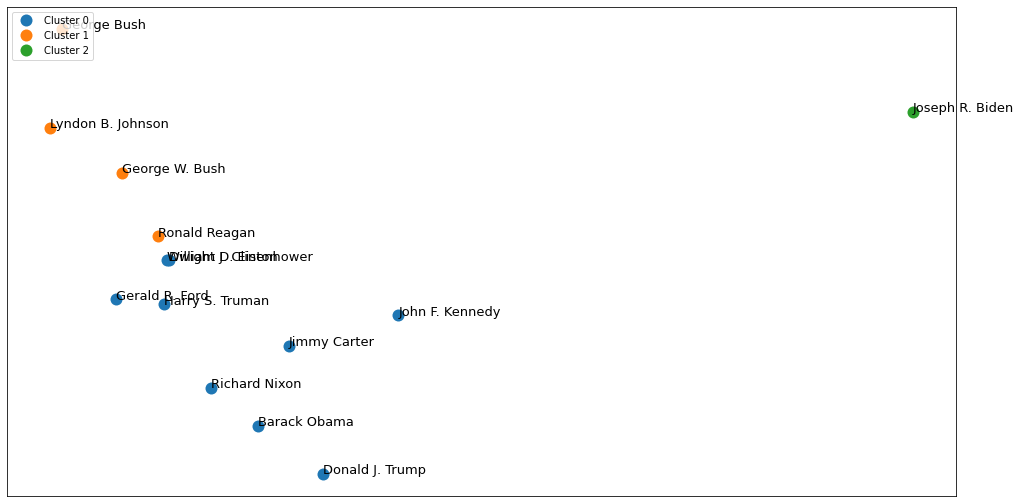

In [36]:
groups = final_dense_df.groupby('Label')
cluster_names_0 = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'}
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.X, group.Y, marker='o', linestyle='', ms=12, 
            label=cluster_names_0[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          
        which='both',       #both major and minor ticks are affected
        bottom=False,      
        top=False,         
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         
        which='both',     
        left=False,      
        top=False,         
        labelleft=False)
    
ax.legend(numpoints=1, loc='upper left')  #show legend with only 1 point

#add label in x,y position with the label as the speech title
for i in range(len(final_dense_df)):
    ax.text(final_dense_df.loc[i]['X'], final_dense_df.loc[i]['Y'], final_dense_df.loc[i]['President'], size=13)  

    
    
plt.show()

NER

In [37]:
def specify_NER(raw_text):
  ents = Counter()
  doc = ner.name(raw_text, language='en_core_web_sm')
  text_label = [(X.text, X.label_) for X in doc]
  for text, label in text_label:
      raw_text = raw_text.replace(text, label)
      ents[f"{label}"] += 1   
  return raw_text, ents

In [38]:
def create_bar_plot(ents, president):
  ents_names, ents_count = zip(*ents.items())
  fig = plt.figure(figsize = (25,4))
 
  # creating the bar plot
  plt.bar(ents_names, ents_count, color ='#5F9EA0')
  
  plt.xlabel("Entity Names")
  plt.ylabel("No. Of Each Entity")
  plt.title(president,fontsize=25)
  plt.show()

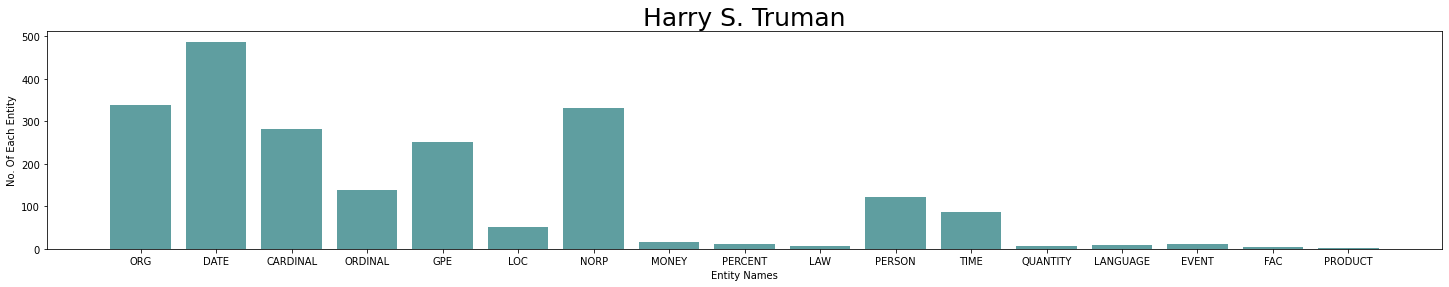

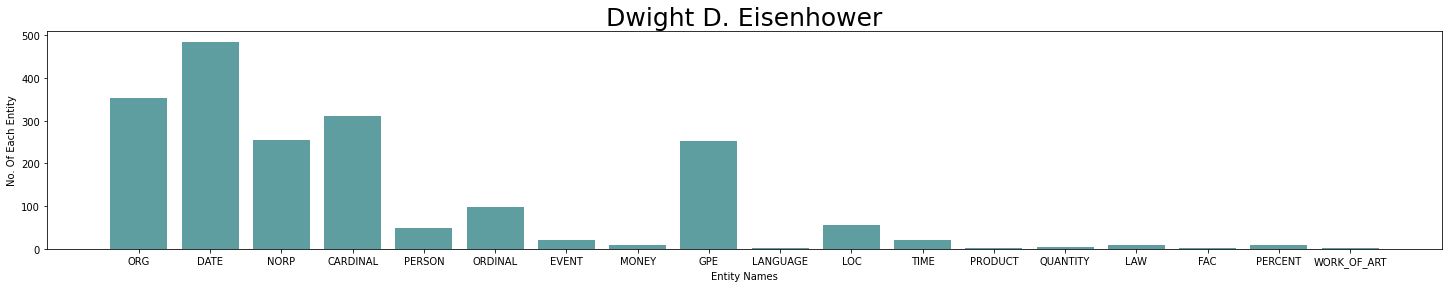

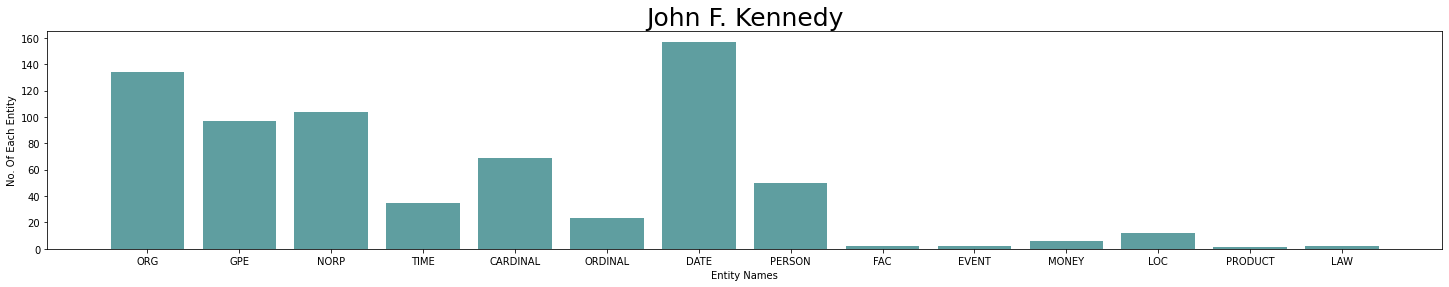

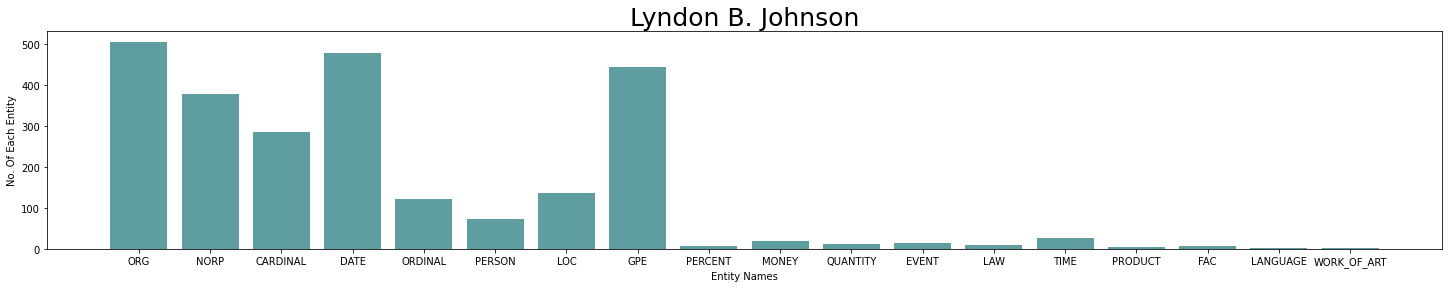

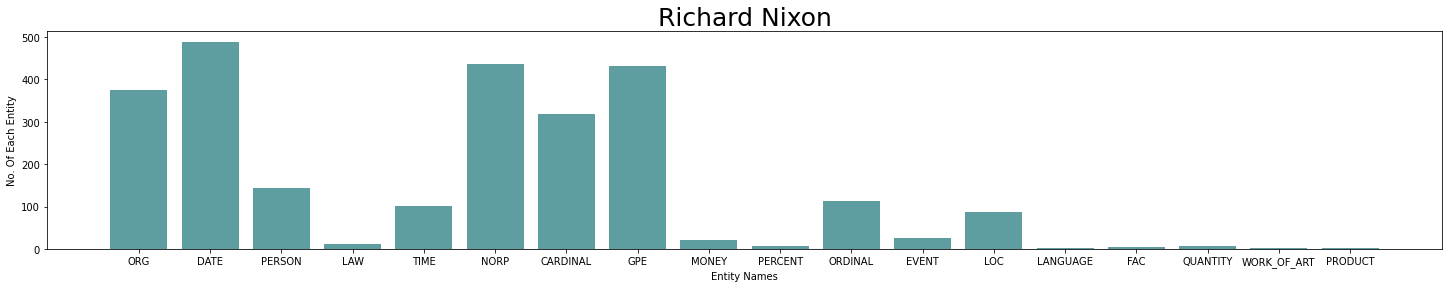

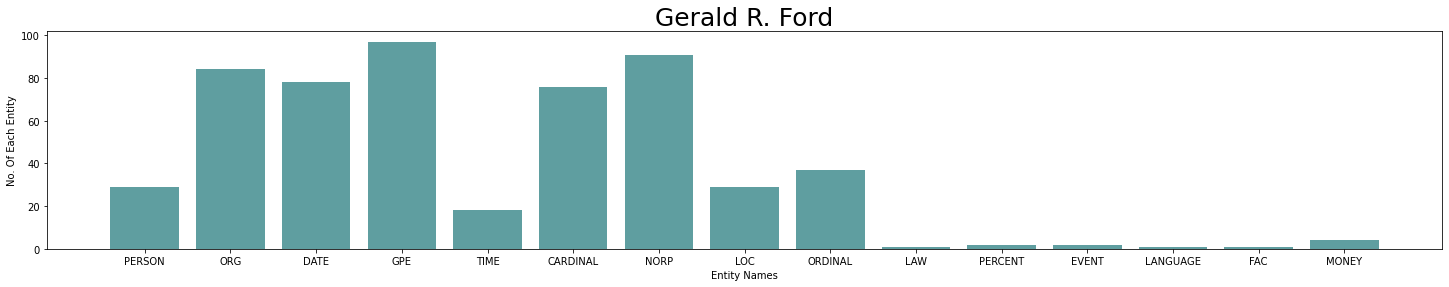

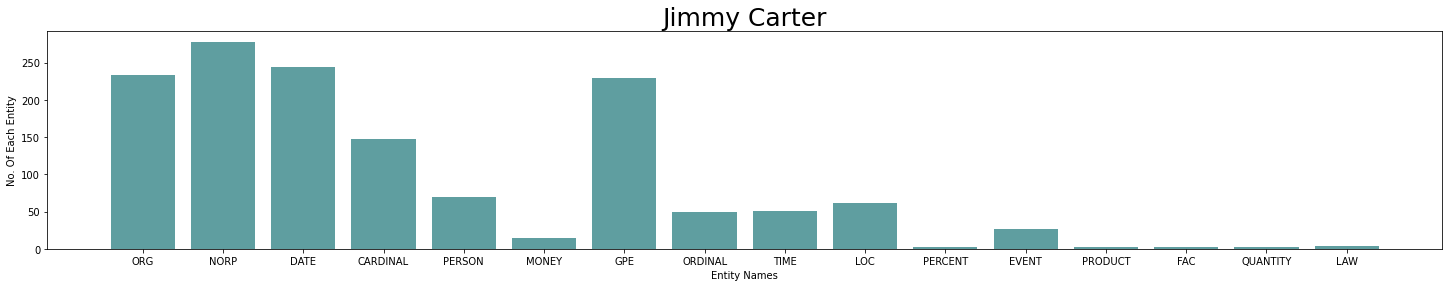

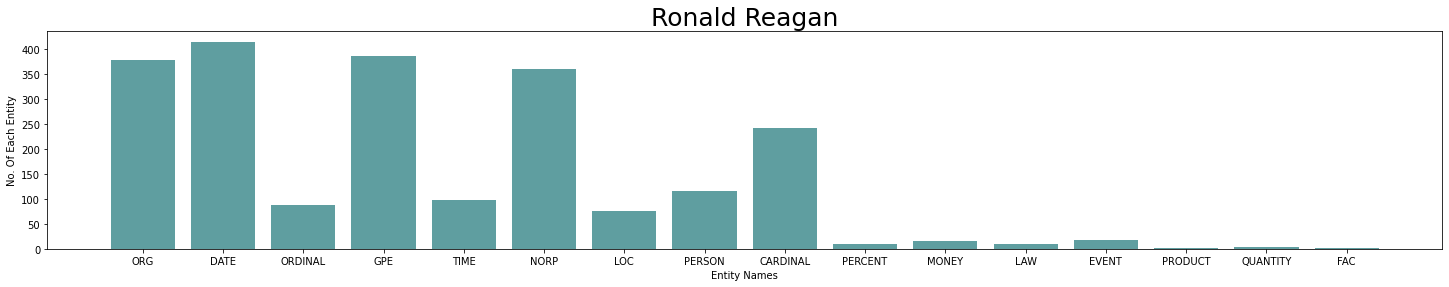

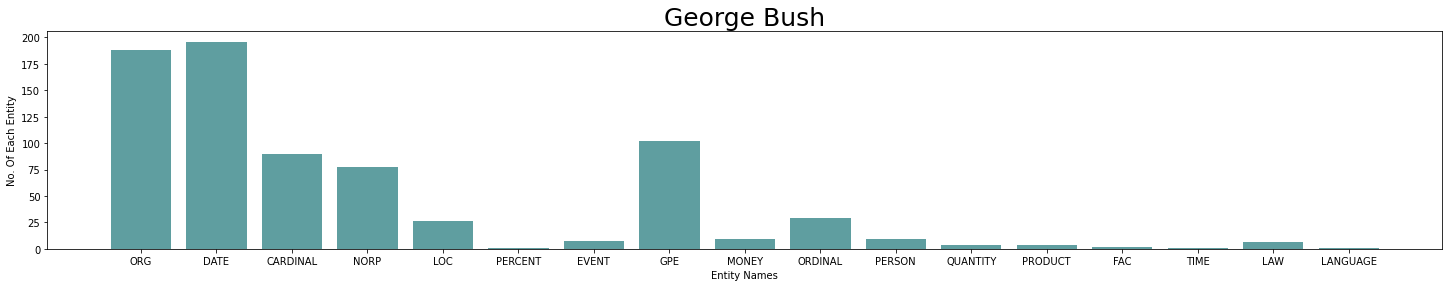

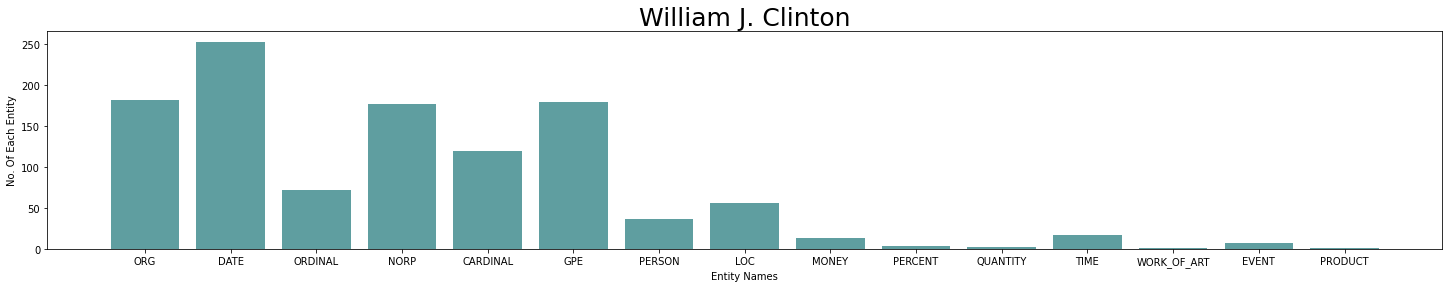

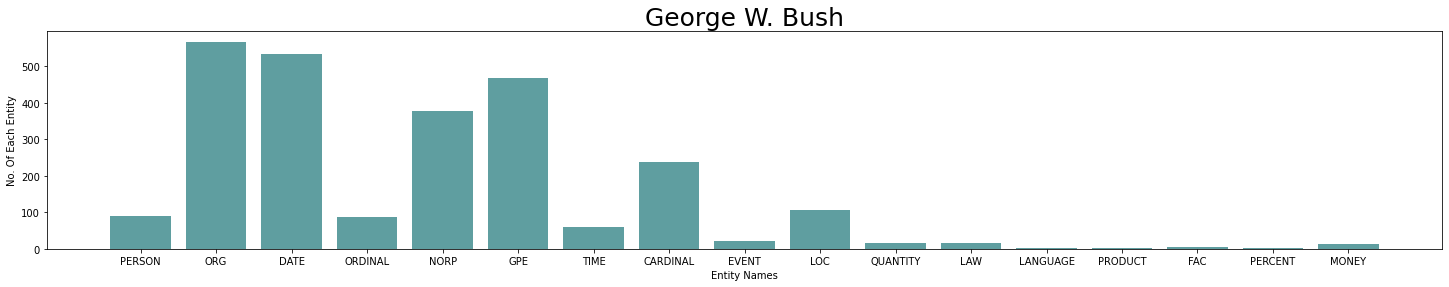

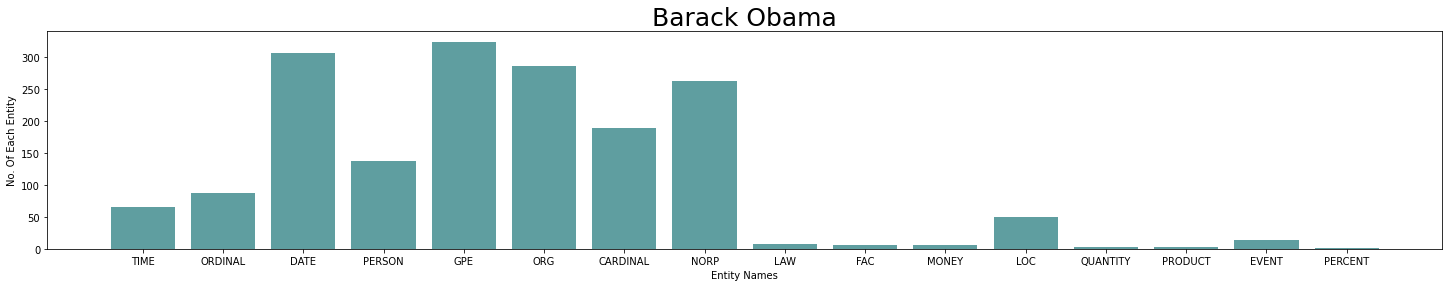

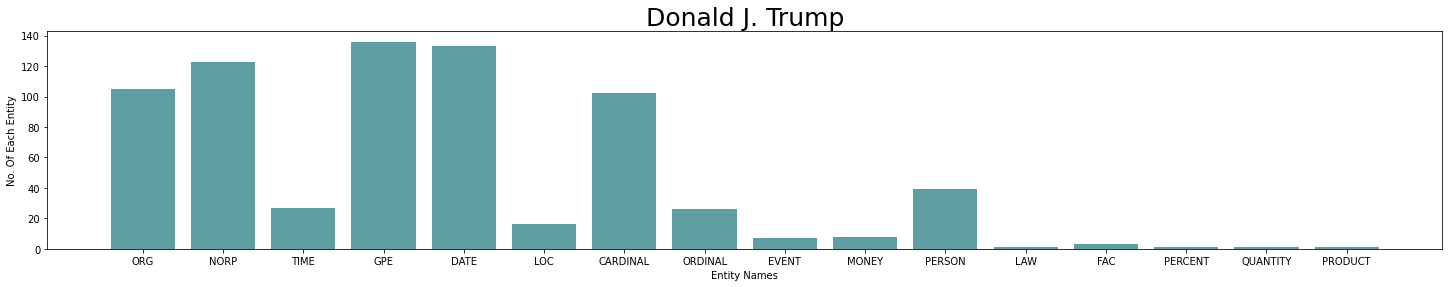

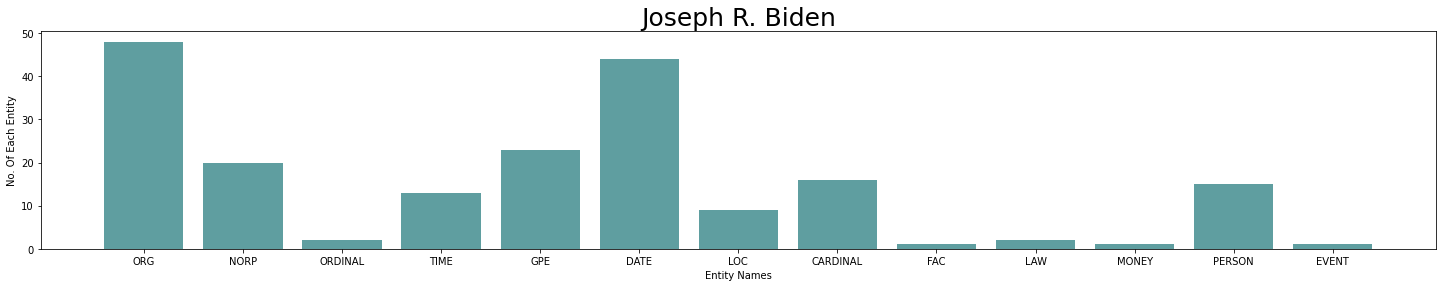

In [39]:
for president, clean_text in cleaned_text_dict.items():
  text , entity_counter = specify_NER(clean_text)
  create_bar_plot(entity_counter,president)
  print('\n')
  print('\n')


In [44]:
# https://github.com/language-ml/1-nlp-exploring-datasets/blob/main/notebooks/ExploreYourTextCollection-English.ipynb
def chunkTechnicalTerm(sentence):
    grammar = r"""
      TECHTERM: {<JJ|NN>+<NN|CD>|<NN>}
    """
    cp = RegexpParser(grammar)
    return (cp.parse(sentence))

In [45]:
def extract_key(dict_of_corpous, min_count):
    president_technical_terms = {}

    for president in dict_of_corpous.keys():
        president_technical_terms[president] = []
        sentences_tagged = []
        corpus_normlized = normalize_and_cleaning(dict_of_corpous[president], lemm=False, stop_word=False, remove_punct=False, remove_number=False)
        sentences = sent_tokenize(corpus_normlized)
        sentences = [normalize_and_cleaning(sen, lemm=False, stop_word=False) for sen in sentences]
        for sent in sentences:
            try:
                sentences_tagged.append(pos_tag(sent.split(' ')))
            except:
                pass
        for the_sentence in sentences_tagged:
            tree=chunkTechnicalTerm(the_sentence)
            for subtree in tree.subtrees():
                if subtree.label() == 'TECHTERM':
                    president_technical_terms[president].append(subtree.leaves())



    for president in president_technical_terms.keys():
        president_technical_terms[president]=FreqDist([' '.join([x for x,y in sent]) for sent in president_technical_terms[president] if len(sent)>1]).most_common(min_count)    


    president_technical_terms = pd.DataFrame(president_technical_terms) 
    president_technical_terms
    return president_technical_terms

In [46]:
join_text_dict = {}
for president, text_list in president_text_dict.items():
  join_text_dict[president] = ' '.join(text_list)

In [47]:
MIN_COUNT = 40
freq_analysis_phrase2 = extract_key(join_text_dict, MIN_COUNT)
freq_analysis_phrase2

,Harry S. Truman,Dwight D. Eisenhower,John F. Kennedy,Lyndon B. Johnson,Richard Nixon,Gerald R. Ford,Jimmy Carter,Ronald Reagan,George Bush,William J. Clinton,George W. Bush,Barack Obama,Donald J. Trump,Joseph R. Biden
0,"(federal government, 28)","(federal government, 30)","(last year, 5)","(federal government, 35)","(last year, 29)","(foreign policy, 10)","(soviet union, 24)","(federal government, 36)","(last year, 19)","(soviet union, 20)","(last year, 32)","(last year, 16)","(first time, 8)","(fiscal year, 3)"
1,"(social security, 21)","(soviet union, 17)","(law enforcement, 5)","(past four, 33)","(federal government, 17)","(federal government, 9)","(free world, 23)","(last year, 26)","(past year, 15)","(federal government, 18)","(soviet union, 30)","(federal government, 14)","(soviet union, 4)","(public service, 2)"
2,"(last year, 17)","(last year, 15)","(same time, 5)","(soviet union, 23)","(social security, 16)","(middle east, 5)","(federal government, 12)","(community development, 12)","(federal government, 15)","(past year, 10)","(federal government, 23)","(first time, 9)","(energy crisis, 4)","(executive branch, 2)"
3,"(first time, 16)","(death penalty, 13)","(past year, 5)","(social security, 20)","(health care, 16)","(world economy, 4)","(last year, 10)","(private sector, 10)","(economic growth, 8)","(middle east, 10)","(past year, 14)","(health insurance, 8)","(fair share, 4)","(incidence crime, 2)"
4,"(health care, 16)","(world war, 12)","(world peace, 4)","(last year, 19)","(first time, 13)","(only way, 4)","(long time, 6)","(saddam hussein, 10)","(soviet union, 8)","(free world, 9)","(first time, 14)","(unemployment rate, 7)","(natural gas, 4)","(congress last year, 2)"
5,"(private sector, 10)","(same time, 11)","(tax bill, 4)","(same time, 17)","(economic growth, 12)","(same time, 4)","(cold war, 6)","(first time, 9)","(private sector, 7)","(same time, 7)","(past three, 12)","(same time, 6)","(middle east, 3)","(kappel report, 2)"
6,"(low income, 9)","(first time, 10)","(first time, 3)","(past year, 15)","(middle class, 12)","(hopeful society, 4)","(quality life, 5)","(past two, 9)","(foreign policy, 6)","(past two, 6)","(health care, 10)","(new economy, 6)","(federal government, 3)","(commission executive, 2)"
7,"(health insurance, 9)","(law enforcement, 10)","(illegal immigration, 3)","(private sector, 13)","(minimum wage, 12)","(rate inflation, 4)","(world war, 5)","(health care, 7)","(free world, 5)","(last year, 6)","(same time, 9)","(right thing, 6)","(last year, 3)","(last year, 2)"
8,"(economic growth, 9)","(past year, 9)","(other side, 3)","(last four, 13)","(middle east, 11)","(tax burden, 3)","(past eight, 5)","(economic growth, 6)","(fiscal year, 5)","(economic growth, 6)","(private sector, 8)","(social security, 5)","(speaker president, 2)","(soviet union, 2)"
9,"(energy crisis, 8)","(executive branch, 9)","(last session, 3)","(first time, 11)","(right thing, 9)","(executive branch, 3)","(social security, 4)","(executive branch, 6)","(new program, 5)","(social security, 4)","(economic growth, 7)","(middle east, 5)","(good land, 2)","(speaker president, 1)"
